In [1]:
import json
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.blocks.stats import BlockStats
from src import Block
from src import PositionalString
from tqdm import tqdm; tqdm.pandas()

In [2]:
# INPUTS
path_max_blocks_stats=Path("out/smk_max_blocks.tsv")
dir_max_blocks=Path("out/blocks/")

# load data
df = pd.read_csv(path_max_blocks_stats,sep="\t", index_col=False, header=0)#, nrows=10)


In [3]:

def path_block_from_msa(path_msa):
    name_msa = Path(path_msa).stem
    return dir_max_blocks.joinpath(f"{name_msa}.json")

def gene_or_intergenic(path_msa):
    if Path(path_msa).stem.startswith("GC"):
        return "genic"
    else:
        return "intergenic"


### Load log data from blocks

- `n_seqs`: number of sequences in the MSA
- `n_unique_seqs`: number of unique sequences in the MSA
- `n_cols`: number of columns in the MSA
- `n_max_blocks`: number of maximal blocks in that MSA
- `n_max_blocks_`: binned `n_max_blocks`
- `t`: time spent computing maximal blocks (in seconds)
- `t [min]`: same `t` in minutes
- `t_[min]`: binned `t [min]`
- `max_blocks/size_msa`: proportion [%] of maximal blocks w.r.t the size of the MSA (`n_cols x n_unique_seqs`)

In [4]:

# time in minutes
df["t [min]"] = df["t"]/60

# binned time in minutes
vec_bins=[0,1,10,15,30,45,60,120,180,300,720,1440,10_000] # bins in minutes
t_label_bins = [f"<{bin}" for bin in vec_bins[1:]]
df["t_[min]"]=pd.cut(df["t [min]"], bins=vec_bins, labels=t_label_bins)

# region
df["region"] = df["path_msa"].apply(gene_or_intergenic)    # genic or intergenic region

# max blocks binned
vec_bins=[0,3,5,10,15,50,100,150,200,300,500,1000,1500] # bins blocks
max_blocks_label_bins = [f"<{bin}" for bin in vec_bins[1:]]
df["n_max_blocks_"]=pd.cut(df["n_max_blocks"], bins=vec_bins, labels=max_blocks_label_bins)

In [5]:
# 1. size_msa = n_rows x n_cols, n_rows: n_unique_seqs in the table
df["max_blocks/size_msa"] = df.apply(lambda row: round(100*row["n_max_blocks"]/(row["n_unique_seqs"]*row["n_cols"]),2),axis=1)

In [6]:
df.head()

,timestamp,path_msa,n_seqs,n_unique_seqs,n_cols,n_max_blocks,t,t [min],t_[min],region,n_max_blocks_,max_blocks/size_msa
0,Sat Oct 29 15:55:34 2022,/data/msas/msas/Cluster_13942.fa,19,2,38,2,0.367273,0.006121,<1,intergenic,<3,2.63
1,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_12332.fa,19,2,57,2,0.793138,0.013219,<1,intergenic,<3,1.75
2,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_11869.fa,4,2,66,4,1.171890,0.019531,<1,intergenic,<5,3.03
3,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_10907.fa,11,2,78,2,1.594922,0.026582,<1,intergenic,<3,1.28
4,Sat Oct 29 15:55:37 2022,/data/msas/msas/Cluster_10644.fa,155,3,82,5,3.114183,0.051903,<1,intergenic,<5,2.03


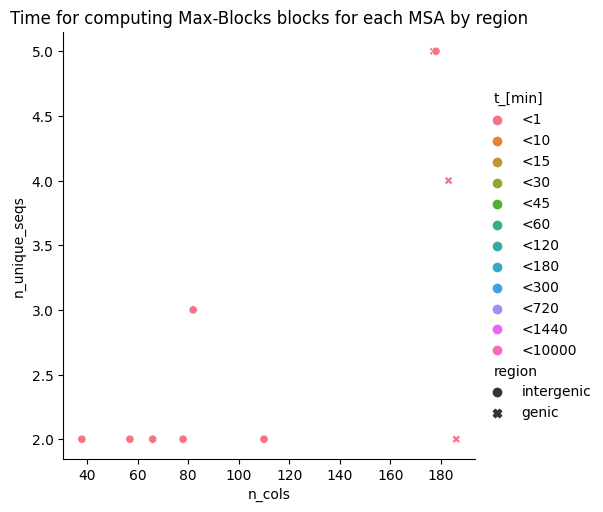

In [8]:
time_plot = sns.relplot(df,
    x="n_cols",
    y="n_unique_seqs",
    hue="t_[min]",
    style="region"
)
time_plot.set(title="Time for computing Max-Blocks blocks for each MSA by region")

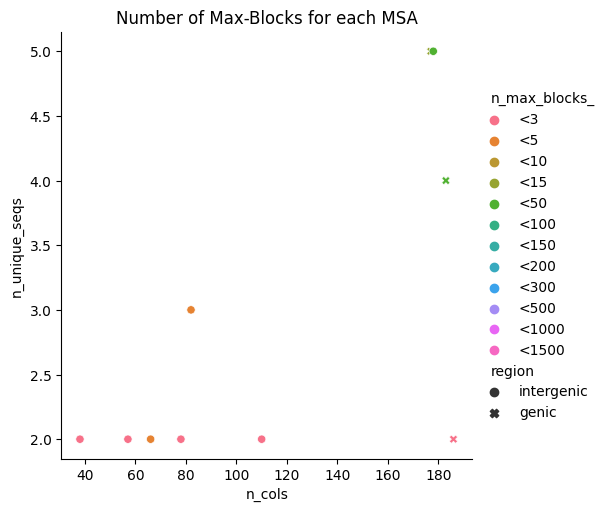

In [9]:
max_block_plot=sns.relplot(df,
    x="n_cols",
    y="n_unique_seqs",
    hue="n_max_blocks_",
    style="region"
)
max_block_plot.set(title="Number of Max-Blocks for each MSA")

# Stats for blocks
- `region`: either Genic or Intergenic
- `number_of_blocks`: number of blocks in the file, in this case is equal to `n_max_blocks`
- `blocks_with_overlap`: number of blocks that overlap at least once with another block
- `inter_between_blocks`: number of intersections between pairs of blocks

In [10]:
# statistics for each block 
block_stats=BlockStats()

df_stats=df.progress_apply(
    lambda row: block_stats(path_blocks=path_block_from_msa(row["path_msa"])),
    axis=1 ) # output is a dictionary
df = pd.concat([df, pd.DataFrame(list(df_stats))], axis=1) # add stats 

df.head()

100%|██████████| 10/10 [00:00<00:00, 735.55it/s]


,timestamp,path_msa,n_seqs,n_unique_seqs,n_cols,n_max_blocks,t,t [min],t_[min],region,n_max_blocks_,max_blocks/size_msa,number_of_blocks,blocks_with_overlap,inter_between_blocks
0,Sat Oct 29 15:55:34 2022,/data/msas/msas/Cluster_13942.fa,19,2,38,2,0.367273,0.006121,<1,intergenic,<3,2.63,2,0,0
1,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_12332.fa,19,2,57,2,0.793138,0.013219,<1,intergenic,<3,1.75,2,0,0
2,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_11869.fa,4,2,66,4,1.171890,0.019531,<1,intergenic,<5,3.03,4,0,0
3,Sat Oct 29 15:55:35 2022,/data/msas/msas/Cluster_10907.fa,11,2,78,2,1.594922,0.026582,<1,intergenic,<3,1.28,2,0,0
4,Sat Oct 29 15:55:37 2022,/data/msas/msas/Cluster_10644.fa,155,3,82,5,3.114183,0.051903,<1,intergenic,<5,2.03,5,3,6


### mean and max of some features by genic/intergenic region


In [11]:
features0=["n_unique_seqs","n_cols"]
features1=["n_max_blocks","t [min]"]
features2=["blocks_with_overlap", "inter_between_blocks"]

In [12]:
df.groupby("region")[features0].describe()

n_unique_seqs                                              n_cols  \
                   count      mean       std  min  25%  50%  75%  max  count   
region                                                                         
genic                3.0  3.666667  1.527525  2.0  3.0  4.0  4.5  5.0    3.0   
intergenic           7.0  2.571429  1.133893  2.0  2.0  2.0  2.5  5.0    7.0   

                                                                 
             mean        std    min    25%    50%    75%    max  
region                                                           
genic       182.0   4.582576  177.0  180.0  183.0  184.5  186.0  
intergenic   87.0  45.931108   38.0   61.5   78.0   96.0  178.0

In [13]:
df.groupby("region")[features1].describe()

n_max_blocks                                                    \
                  count       mean        std  min  25%   50%   75%   max   
region                                                                      
genic               3.0  14.666667  13.012814  2.0  8.0  14.0  21.0  28.0   
intergenic          7.0   5.714286   7.273566  2.0  2.0   3.0   4.5  22.0   

           t [min]                                                    \
             count      mean       std       min       25%       50%   
region                                                                 
genic          3.0  0.327707  0.102418  0.210702  0.291006  0.371309   
intergenic     7.0  0.085153  0.152250  0.006121  0.016375  0.026582   

                                
                 75%       max  
region                          
genic       0.386209  0.401108  
intergenic  0.051250  0.428117

In [14]:
df.groupby("region")[features2].describe()

blocks_with_overlap                                              \
                         count       mean        std  min  25%   50%   75%   
region                                                                       
genic                      3.0  13.333333  13.503086  0.0  6.5  13.0  20.0   
intergenic                 7.0   3.428571   7.828519  0.0  0.0   0.0   1.5   

                 inter_between_blocks                                         \
             max                count       mean        std  min   25%   50%   
region                                                                         
genic       27.0                  3.0  64.333333  55.824129  0.0  46.5  93.0   
intergenic  21.0                  7.0  27.857143  71.092495  0.0   0.0   0.0   

                         
             75%    max  
region                   
genic       96.5  100.0  
intergenic   3.0  189.0

___
## Draft [do not consider]

In [15]:
from src.blocks.block_decomposition import block_decomposition
from src.blocks.block import Block

In [16]:
b1 = Block([1,2,3],1,5,"ACGTT")
b2 = Block([2,3],1,3,"ACG")
block_decomposition(b1,b2)

Condicion1


[Block(K=[2, 3], i=1, j=3, label='ACG'),
 Block(K=[1, 2, 3], i=4, j=5, label='TT')]

In [17]:
b1 = Block([2,3],1,5,"ACGTT")
b2 = Block([1,2,3],2,4,"CGT")

block_decomposition(b1,b2)

Condicion2


[Block(K=[2, 3], i=1, j=1, label='A'),
 Block(K=[1, 2, 3], i=2, j=4, label='CGT'),
 Block(K=[2, 3], i=5, j=5, label='T')]

In [18]:
b1 = Block([1,2],1,5,"ACGTT")
b2 = Block([1,2,3],4,5,"TT")
block_decomposition(b1,b2)

Condicion3


[Block(K=[1, 2], i=1, j=3, label='ACG'),
 Block(K=[1, 2, 3], i=4, j=5, label='TT')]

In [19]:
b1 = Block([1,2],1,4,"ACGT")
b2 = Block([2,3],3,5,"GTT")
block_decomposition(b1,b2)

Condicion4


[Block(K=[1, 2], i=1, j=2, label='AC'),
 Block(K=[2, 3], i=3, j=5, label='GTT'),
 Block(K=[1, 2], i=1, j=4, label='ACGT'),
 Block(K=[2, 3], i=5, j=5, label='T')]